## Part 1: Exploratory Data Analysis

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, accuracy_score, roc_auc_score

In [2]:
data = pd.read_json('logins.json')
data.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
# Set Index to 'login_time' to perform DatetimeIndex operations

data.set_index('login_time', inplace=True)
data.head(2)

""
login_time
1970-01-01 20:13:18
1970-01-01 20:16:10


In [5]:
print(data.index.freq)

None


In [6]:
# Add a column to save the aggregation values

data['login_count'] = np.arange(len(data))

In [7]:
# Aggregate the login counts based on 15 minute time intervals

data = data.resample('15T').sum()

print('The Time Series frequency is', data.index.freq)

print(data.head())

The Time Series frequency is <15 * Minutes>
                     login_count
login_time                      
1970-01-01 20:00:00          6.0
1970-01-01 20:15:00         25.0
1970-01-01 20:30:00        113.0
1970-01-01 20:45:00        132.0
1970-01-01 21:00:00         25.0


In [8]:
data.isnull().sum()

login_count    407
dtype: int64

During the four month period, there are 407 fifteen minute intervals when there were no logins

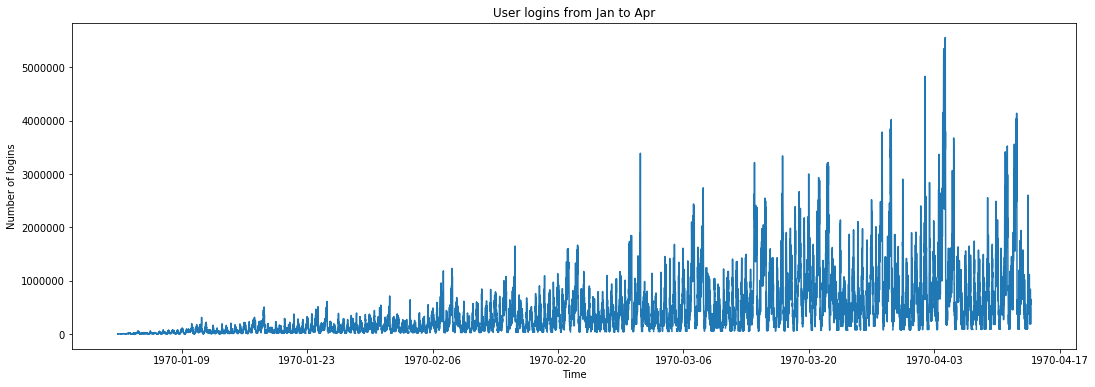

In [9]:
plt.figure(figsize=(18,6))
plt.plot(data)
plt.title('User logins from Jan to Apr')
plt.ylabel('Number of logins')
plt.xlabel('Time')
plt.show()

The plot shows a cyclical pattern - low activity for a period ot time followed by a spike in activity and low again. There is an increasing trend of user logins from January to April. There were fewer logins at he beginning of the year, and the number of logins went up as the year progressed. The month of April had the highest number of logins.

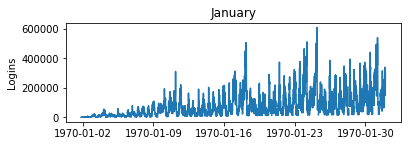

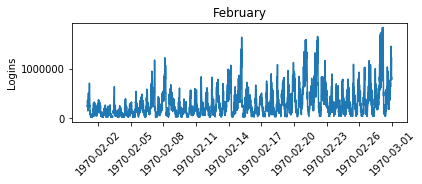

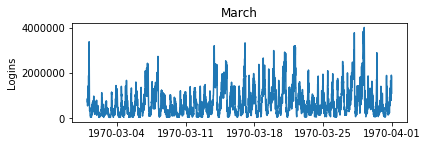

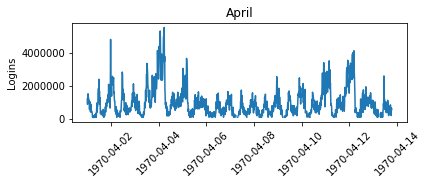

In [10]:
plt.subplot(2,1,1)
plt.plot(data.loc['1970-01'])
plt.title('January')
plt.ylabel('Logins')
plt.show()

plt.subplot(2,1,2)
plt.plot(data.loc['1970-02'])
plt.xticks(rotation=45)
plt.title('February')
plt.ylabel('Logins')
plt.show()

plt.subplot(2,1,1)
plt.plot(data.loc['1970-03'])
plt.title('March')
plt.ylabel('Logins')
plt.show()

plt.subplot(2,1,2)
plt.plot(data.loc['1970-04'])
plt.xticks(rotation=45)
plt.title('April')
plt.ylabel('Logins')
plt.show()

Visualizing the plots for the four months, we can see a trend of higher logins on weekends. Though there is a high activity on weekdays too in the month of March. This trend is not quite visible in April because the data for the second half of April is missing. So, the plot looks stretched out as compared to the other three plots. 

## Part 2: Experiment and Metrics Design

Key metric to measure success - The number of Ultimate vehicles crossing the Toll bridge everyday in both directions, treating weekends and weekdays separately. 

An increase in the number of Ultimate cars going over the bridge will indicate success.

Statistical Test

x = average number of vehicles crossing the bridge
d = number of vehicles crossing the bridge per day

Null Hypothesis:  x - d = 0 
Alternate Hypothesis : x - d > 0 
Significance level: 0.05

The experiment will help us determine whether the experiment is working.
The traffic over the Toll bridge should ideally increase after Ultimate covers the cost of the toll. We can get a percentage of vehicles going in eithe direction, and based on that number assess if there is a highr demand and in either city and if Ultimate needs to invest in more vehicles in that city.

z_score with a 95% confidence interval would be a good measure of significance. We can get a sample size greater than 30.

## Part 3: Predictive Modeling

In [11]:
with open('ultimate_data_challenge.json', 'r') as datafile:
    user_data = json.load(datafile)
user_df = pd.DataFrame(user_data)

user_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [12]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


There is missing data in three columns - avg_rating_by_driver, avg_rating_of_driver, phone 
Date columns last_trip_date, signup_date are of type object

In [13]:
user_df.avg_rating_by_driver.isnull().sum()

201

In [14]:
user_df.avg_rating_of_driver.isnull().sum()

8122

In [15]:
user_df.phone.isnull().sum()

396

In [16]:
# Convert dates to a datetime object

user_df['last_trip_date'] = pd.to_datetime(user_df['last_trip_date'])
user_df['signup_date'] = pd.to_datetime(user_df['signup_date'])

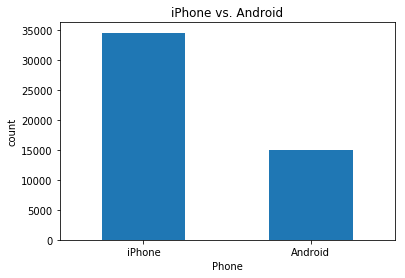

In [17]:
ph_count = user_df.phone.value_counts()
ph_count.plot(kind = 'bar')
plt.xticks(rotation='horizontal')
plt.title('iPhone vs. Android')
plt.xlabel('Phone')
plt.ylabel('count')
plt.show()

Since the number of iPhones is significantly higher than Android, we will fill the missing values with iPhone.

In [18]:
user_df.phone.fillna('iPhone', inplace=True)

user_df.phone.isnull().any()

False

In [19]:
# Fill missing values with the mean of the column 

user_df.avg_rating_by_driver.fillna(user_df.avg_rating_by_driver.mean(), inplace=True)

user_df.avg_rating_of_driver.fillna(user_df.avg_rating_of_driver.mean(), inplace=True)

In [20]:
user_df.avg_rating_by_driver.isnull().any()

False

In [21]:
user_df.avg_rating_of_driver.isnull().any()

False

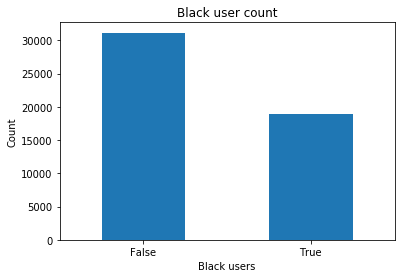

In [22]:
blackuser_count = user_df.ultimate_black_user.value_counts()
blackuser_count.plot(kind = 'bar')
plt.xticks(rotation='horizontal')
plt.title('Black user count')
plt.xlabel('Black users')
plt.ylabel('Count')
plt.show()

In [23]:
# Confirming that all users signed up in January

sorted(user_df['signup_date'].unique())[-5:]

[numpy.datetime64('2014-01-27T00:00:00.000000000'),
 numpy.datetime64('2014-01-28T00:00:00.000000000'),
 numpy.datetime64('2014-01-29T00:00:00.000000000'),
 numpy.datetime64('2014-01-30T00:00:00.000000000'),
 numpy.datetime64('2014-01-31T00:00:00.000000000')]

In [24]:
# When was the data pulled?

sorted(user_df['last_trip_date'].unique())[-5:]

[numpy.datetime64('2014-06-27T00:00:00.000000000'),
 numpy.datetime64('2014-06-28T00:00:00.000000000'),
 numpy.datetime64('2014-06-29T00:00:00.000000000'),
 numpy.datetime64('2014-06-30T00:00:00.000000000'),
 numpy.datetime64('2014-07-01T00:00:00.000000000')]

We can see that data was pulled on 2014-07-01. Users are retained if they took a trip in the preceeding 30 days. i.e. in the month of of June.

In [25]:
# Calculate fraction of users that were retained

users_retained = len(user_df[user_df['last_trip_date'] >= '2014-06-01']) / len(user_df) 

print(round(users_retained * 100), '% of the users were retained')

38 % of the users were retained


### Data preprocessing and model building

Since we have two posssible labels for the target variable, this is a binary Classification problem. We will use the Logistic Regression Classifier. It is a simple fast, and easy algorithm to use for our linearly separable data, and it can derive feature significance. KNN, SVM, Random Forest Classifier and Decision Tree Classifiers are other options.   

A Decision Tree Classifier would be the next one to try if Logistic Regression gives a low f1-score. It may give a better accuracy and a different set of predictors.


In [26]:
# Create a new column for the target variable. Populate it with 1 if a user is retained, and 0 if a user is  not retained

user_df['retained_users'] = np.nan

user_df.loc[user_df.last_trip_date >= '2014-06-01', 'retained_users'] = 1
user_df.loc[user_df.last_trip_date < '2014-06-01', 'retained_users'] = 0

In [27]:
# Drop the date columns as they are not needed anymore

user_df.drop(['last_trip_date', 'signup_date'], axis=1, inplace=True)

In [28]:
# One hot encode categorical variables

user_df_encoded = pd.get_dummies(user_df, columns = ['city', 'phone', 'ultimate_black_user'])
user_df_encoded.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,retained_users,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,3.67,5.0,4.7,1.10,15.4,4,46.2,1.0,0,1,0,0,1,0,1
1,8.26,5.0,5.0,1.00,0.0,0,50.0,0.0,1,0,0,1,0,1,0
2,0.77,5.0,4.3,1.00,0.0,3,100.0,0.0,1,0,0,0,1,1,0
3,2.36,4.9,4.6,1.14,20.0,9,80.0,1.0,0,1,0,0,1,0,1
4,3.13,4.9,4.4,1.19,11.8,14,82.4,0.0,0,0,1,1,0,1,0


In [29]:
# Create X and y and convert them to numpy arrays, split data into train and test

y = user_df_encoded.retained_users.values
X = user_df_encoded.drop(['retained_users'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Build the model and predict  

logreg = LogisticRegression()

c_space = np.logspace(5, 10, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

logreg_cv.fit(X_train, y_train)
y_pred = logreg_cv.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print('Accuracy Score:', accuracy_score(y_test, y_pred))

print('Best parameters: ', logreg_cv.best_params_)
print('Best Score: ', logreg_cv.best_score_)

[[5245  974]
 [1883 1898]]
             precision    recall  f1-score   support

        0.0       0.74      0.84      0.79      6219
        1.0       0.66      0.50      0.57      3781

avg / total       0.71      0.71      0.70     10000

Accuracy Score: 0.7143
Best parameters:  {'C': 13894954.94373136, 'penalty': 'l1'}
Best Score:  0.718325


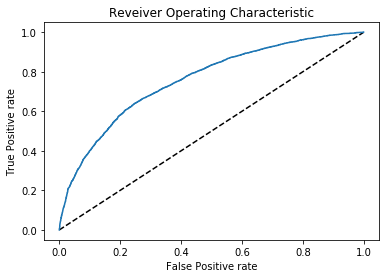

In [31]:
y_pred_proba = logreg_cv.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.title('Reveiver Operating Characteristic')
plt.ylabel('True Positive rate')
plt.xlabel('False Positive rate')
plt.show()

In [32]:
roc_auc_score(y_test, y_pred_proba)

0.7588958451587156

From the AUC plot and the score we can see that the performance of the model can be improved

## How valid is your model?

It is a baseline model. It has an low accuracy score of 71%, which can be improved by 
* hyperparameter tuning 
* removing ouliers (if any)
* checking for correlation and removing variables that are highly correlated


### How might Ultimate leverage the insights gained from the model to improve it's own long-term rider retention?

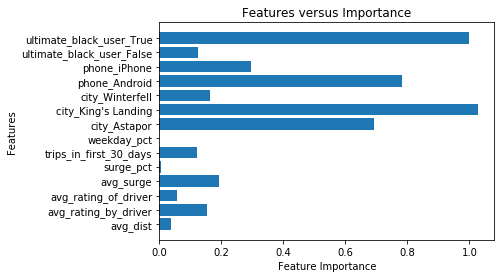

                     features  importance
0                    avg_dist    0.036618
1        avg_rating_by_driver    0.153231
2        avg_rating_of_driver    0.055113
3                   avg_surge    0.191111
4                   surge_pct    0.004576
5      trips_in_first_30_days    0.121590
6                 weekday_pct    0.000117
7                city_Astapor    0.692014
8         city_King's Landing    1.028746
9             city_Winterfell    0.163953
10              phone_Android    0.783773
11               phone_iPhone    0.295874
12  ultimate_black_user_False    0.124250
13   ultimate_black_user_True    0.999629


In [34]:
# Plot feature importance 

features = X = user_df_encoded.drop(['retained_users'], axis=1).columns

best_estimator = logreg_cv.best_estimator_
feature_importance = abs(best_estimator.coef_[0])

df = pd.DataFrame({'features':features, 'importance': feature_importance})

plt.barh(range(len(features)), feature_importance)
plt.yticks(range(len(features)), features)
plt.title('Features versus Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()
print(df)

Ultimate should focus on the top 3-4 predictors:
* The city of Kings Landing is the most important predictor.. Why is Ultimate unable to retain users from Astapor and Winterfell? We can evaluate the driver_ratings by users in these two cities. 
* More black users are retained compared to non-black users. Why?
* Android Phone is an important predictor. Perhaps, it is easier to book a ride with the Android phone, the iPhone app may not as user-friendly.

In addition, it will be useful to have data for all 6 months as opposed to one month for users who signed up 4-5 months ago. This may help us to get a better insight into user activity and hence the retention rate. 